## Simple source modeling
Trying to iron out all the confusion on how to calculate source parameters

In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

t, a, b, c, f = sym.symbols('t a b c f')

## Source Model

We will use a simple guassian as a source model.

In [3]:
# Get gausian and derivative/integral
gaus = a * sym.exp((-(t - b)**2) / (2 * c **2))
d_gaus = sym.diff(gaus, t)
int_gaus = sym.integrate(gaus, t)
dd_gaus = sym.diff(d_gaus, t)

In [ ]:
# get freq domain
F_gaus = sym.fourier_transform(gaus, t, f).rewrite(sym.Integral)
F_d_gaus = sym.fourier_transform(d_gaus, t, f).rewrite(sym.Integral)
F_int_gaus = sym.fourier_transform(int_gaus, t, f).rewrite(sym.Integral)

In [4]:
gaus

a*exp(-(-b + t)**2/(2*c**2))

In [5]:
d_gaus

-a*(-2*b + 2*t)*exp(-(-b + t)**2/(2*c**2))/(2*c**2)

In [6]:
dd_gaus

-a*exp(-(-b + t)**2/(2*c**2))/c**2 + a*(-2*b + 2*t)**2*exp(-(-b + t)**2/(2*c**2))/(4*c**4)

## Get numpy functions

In [8]:
get_gaus = sym.lambdify([t, a, b, c], gaus)
get_d_gaus = sym.lambdify([t, a, b, c], d_gaus)
get_int_gaus = sym.lambdify([t, a, b, c], int_gaus)
get_dd_gaus = sym.lambdify([t, a, b, c], dd_gaus)

## Next generate source time series and plot

In [9]:
# get source in 1) displacement 2) velocity
dt = 0.01
t1, t2 = 2, 8
a, b, c = 0.1, 5, np.sqrt(2)
x = np.arange(0, 10, dt)


source_disp = get_gaus(x, a=a, b=b, c=c)
source_vel = get_d_gaus(x, a=a, b=b, c=c)
source_accel = get_dd_gaus(x, a=a, b=b, c=c)

In [22]:
t = x
denom = 2 * c ** 2
exp = -1 *(t - b) ** 2 / denom
source_disp_eq = a * np.exp(exp)

Text(0, 0.5, 'displacement amplitude (m)')

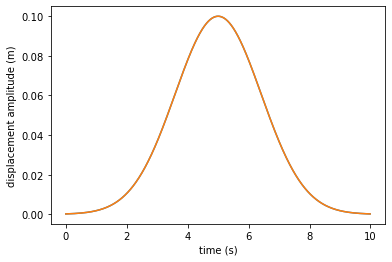

In [23]:
plt.plot(x, source_disp)
plt.plot(x, source_disp_eq)
plt.xlabel('time (s)')
plt.ylabel('displacement amplitude (m)')

In [27]:
fact = 2*t - 2*b
source_vel_eq = -a*fact*np.exp(exp)/denom

Text(0, 0.5, 'velocity amplitude (m/s)')

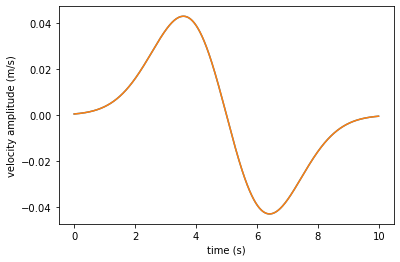

In [28]:
plt.plot(x, source_vel)
plt.plot(t, source_vel_eq)
plt.xlabel('time (s)')
plt.ylabel('velocity amplitude (m/s)')

In [29]:
source_accel_eq = -a*np.exp(exp)/(denom/2) + a*fact**2*np.exp(exp)/denom**2

Text(0, 0.5, 'acceleration amplitude (m/s^2)')

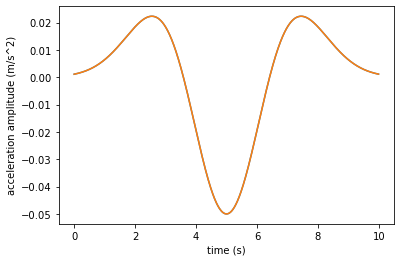

In [30]:
plt.plot(x, source_accel)
plt.plot(t, source_accel_eq)
plt.xlabel('time (s)')
plt.ylabel('acceleration amplitude (m/s^2)')

## Moments
First we estimate the moment (or something proporcional to it) in time domain and compare the results to the freq domain.

### Time domain

In [ ]:
# get moment from t1 to t2
x_in_time = (x > t1) & (x < t2)

In [ ]:
moment_td = np.trapz(source_disp, dx=x[1] - x[0])

### Freq. domain

In [ ]:
def get_fft(ar, dt):
    """Return the fft of the array and its """
    fft_ar = np.fft.rfft(ar) * dt
    freq = np.fft.rfftfreq(len(ar), dt)
    return freq, fft_ar

In [ ]:
freqs, source_disp_fft = get_fft(source_disp, dt)

In [ ]:
plt.loglog(freqs, abs(source_disp_fft))
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')

In [ ]:
moment_fd = abs(source_disp_fft)[0]

In [ ]:
print(moment_td, moment_fd)

## Energy
Next we estimate energy and the equivalent in the freq domain.

## Time domain energy

In [ ]:
source_energy = source_vel ** 2

In [ ]:
plt.plot(x, source_energy)
plt.xlabel('time (s)')
plt.ylabel('amplitude (m/s)')

In [ ]:
# energy_td = np.trapz(source_energy, dx=dt)
energy_td = np.sum(source_energy)

## Frequency domain energy

In [ ]:
def get_ppsd(ar, dt):
    """Get the power spectral density? Or something close to it ;)"""
    print(ar.min(), ar.max())
    fft = np.fft.rfft(ar)
    print(abs(fft).min(), abs(fft).max())
    fft_ar_sq = fft ** 2
    print(abs(fft_ar_sq).min(), abs(fft_ar_sq).max())
    N = len(ar) # this needs to be number of *Non zero* components
    out = fft_ar_sq * (dt / N)
    print(abs(out).min(), abs(out).max())
    # double non zero components to account for neg. frequencies
    out[1:] *= 2
    print(abs(out).min(), abs(out).max())
    freq = np.fft.rfftfreq(len(ar), dt)
    return freq, out

In [ ]:
freqs, ppsd = get_ppsd(source_vel[:len(source_vel)//2], dt)
freqs, ppsd = get_ppsd(source_vel, dt)
plt.loglog(freqs, abs(ppsd))
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')

In [ ]:
spa = np.trapz(source_vel**2, dx=dt)
spb = np.sum(abs(get_ppsd(source_vel, dt)[1]))
assert np.isclose(spa, spb)

In [ ]:
print(spa, spb)